In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf
import pandas as pd

### Reading in and preprocessing our data
Our data is images, and we will be reading in our images from CSV format. Each row will be an image and each column represents a pixel. We will be reading in this data, converting non-numerical data to numbers by using a `label_encoder`, we will shuffle our data, normalize it, and reshape the row to a 64x64 image.

In [2]:
data = pd.read_csv("../input/chinese-mnist-digit-recognizer/chineseMNIST.csv").dropna()
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [3]:
import sklearn.preprocessing
le = sklearn.preprocessing.LabelEncoder()
le.fit(data["character"])
data["character"] = le.transform(data["character"])

In [4]:
data["character"].value_counts()

0     1000
8     1000
1     1000
9     1000
2     1000
10    1000
3     1000
11    1000
4     1000
12    1000
5     1000
13    1000
6     1000
14    1000
7     1000
Name: character, dtype: int64

In [5]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
6403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
3412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1000,11
5074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100000000,7
2749,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100,13
12769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,9


In [24]:
X = data.drop("label", axis=1).drop("character", axis=1)
y = data["character"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train  = X_train / 255.
X_test =  X_test / 255.

X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12000, 64, 64, 1), (3000, 64, 64, 1), (12000,), (3000,))

### Visualizing
In order to visualize our data, we will randomly display and image from the dataset.

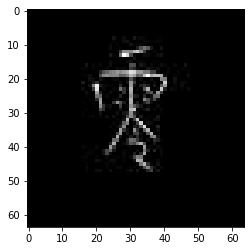

In [12]:
import random 
def display_random_image():
    index = random.randint(0, 14999)
    current_image = data.drop("label", axis=1).drop("character", axis=1).iloc[index].to_numpy()
    current_image = current_image.reshape((64, 64))
    label = data["label"].iloc[index]
    character = data["character"].iloc[index]
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
display_random_image()

### Creating the model
We will be using a convoluional neural network, and we will be creating the CNN with TensorFlow. We use the Adam optimizer with it's default learning rate of 0.001. We also add dropout and an early stopping callback in order to prevent overfitting. Our early stopping callback has took action and stopped training on epoch 8 out of epoch 10, since the validation loss was fluctuating.

In [13]:
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 3, input_shape=(64, 64, 1), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(64, 3,activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(128, 3,activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(128, 3,activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(512, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(15, activation=tf.keras.activations.softmax)
])


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, callbacks=[callback])

Epoch 1/10
338/338 [==============================] - 64s 188ms/step - loss: 1.4464 - accuracy: 0.5201 - val_loss: 0.1547 - val_accuracy: 0.9475
Epoch 2/10
338/338 [==============================] - 63s 186ms/step - loss: 0.1898 - accuracy: 0.9345 - val_loss: 0.0879 - val_accuracy: 0.9717
Epoch 3/10
338/338 [==============================] - 63s 187ms/step - loss: 0.1048 - accuracy: 0.9659 - val_loss: 0.0421 - val_accuracy: 0.9833
Epoch 4/10
338/338 [==============================] - 62s 183ms/step - loss: 0.0758 - accuracy: 0.9748 - val_loss: 0.0814 - val_accuracy: 0.9767
Epoch 5/10
338/338 [==============================] - 62s 183ms/step - loss: 0.0623 - accuracy: 0.9815 - val_loss: 0.0295 - val_accuracy: 0.9908
Epoch 6/10
338/338 [==============================] - 64s 189ms/step - loss: 0.0402 - accuracy: 0.9867 - val_loss: 0.0806 - val_accuracy: 0.9750
Epoch 7/10
338/338 [==============================] - 64s 189ms/step - loss: 0.0455 - accuracy: 0.9871 - val_loss: 0.0424 - val_ac

### Predicting
In order to evaluate our model, we will predict a random image from the test dataset. 

In [31]:
def predict_random():
    rand =  data.sample()
    current_image = rand.drop("label", axis=1).drop("character", axis=1).to_numpy()
    current_image = current_image.reshape((1, 64, 64, 1))
    label = rand["label"]
    character = rand["character"]
    predicted_character =  np.argmax(tf.squeeze(model.predict(current_image).astype(int)))
    print("Prediction:", le.inverse_transform(np.expand_dims(predicted_character, axis=0))[0])
    print("Character:", le.inverse_transform(np.expand_dims(character, axis=0))[0])
    plt.gray()
    plt.imshow(tf.squeeze(current_image))
    plt.show()

Prediction: 八
Character: 八


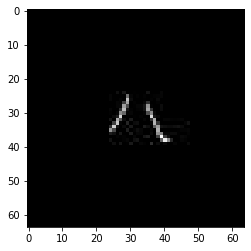

In [33]:
predict_random()

### Final remarks
Our model has done great with a very good accuracy and loss score. It has predicted right for almost all of the images.